# Lecture 18 Part 1 - Linear Discriminant Analysis: Logistic Regression

## Final Discussions about Fisher's LDA

**Limitations** of LDA:

1. LDA produces at most $C-1$ feature projections, where $C$ is the number of classes.

2. If the classification error estimates establish that more features are needed, some other method must be employed to provide those additional features.

3. LDA is a parametric method (it assumes unimodal Gaussian likelihoods).

4. If the distributions are significantly non-Gaussian, the LDA projections may not preserve complex structure in the data needed for classification.

5. LDA will also fail if discriminatory information is not in the mean but in the variance of the data.

A popular variant of LDA are the **Multi-Layer Perceptrons** (or MLPs).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [ ]:
def fisherDiscriminant(data,t):
    data1 = data[t==0,:]
    data2 = data[t==1,:]
    mean1 = np.atleast_2d(np.mean(data1,0))
    mean2 = np.atleast_2d(np.mean(data2,0))
    Sw1 = np.dstack([(data1[i,:]-mean1).T@(data1[i,:]-mean1) for i in range(data1.shape[0])])
    Sw2 = np.dstack([(data2[i,:]-mean2).T@(data2[i,:]-mean2) for i in range(data2.shape[0])])
    Sw = np.sum(Sw1,2) + np.sum(Sw2,2)
    w = np.linalg.inv(Sw)@(mean2 - mean1).T
    w = w/np.linalg.norm(w)
    data_t = data@w
    return w, data_t

def discriminant(data, labels, v):
    v_perp = np.array([v[1], -v[0]])
    b = ((np.mean(data[labels==0,:],axis=0)+np.mean(data[labels==1,:],axis=0))/2)@v
    lambda_vec = np.linspace(-3,3,len(data))
    v_line = lambda_vec * v
    decision_boundary = b * v + lambda_vec * v_perp
    return v_line, decision_boundary

# Generate Synthetic Data
N1 = 100 #number of points for class1
N2 = 100 #number of points for class0
covM = [1,0.01]*np.eye(2) # covariance matrix
data = np.random.multivariate_normal([0,0], covM, N1) #generate points  for class 1
X = np.vstack((data, np.random.multivariate_normal([1,1], covM, N2))) #generate points for class 0
labels = np.hstack((np.ones(N1),np.zeros(N2)))

plt.scatter(X[:,0],X[:,1],c=labels); plt.show();

In [ ]:
v, Y = fisherDiscriminant(X,labels)

plt.figure(figsize=(10,5))
plt.scatter(X[:,0],X[:,1],c=labels)

v_line, decision_boundary = discriminant(X, labels, v);

plt.plot(v_line[0], v_line[1], 'red', linewidth=3, label='Direction of Projection')
plt.plot(decision_boundary[0,:], decision_boundary[1,:],'blue',linewidth=3, label='Decision Boundary')
plt.title('LDA'); plt.axis('equal'); plt.legend(loc='best',fontsize=15);

---

### Limitations of LDA:

1. LDA produces at most $K-1$ feature projections, where $K$ is the number of classes.

2. If the classification error estimates establish that more features are needed, some other method must be employed to provide those additional features.

3. LDA is a parametric method (it assumes unimodal Gaussian likelihoods).

4. If the distributions are significantly non-Gaussian, the LDA projections may not preserve complex structure in the data needed for classification.

5. LDA will also fail if discriminatory information is not in the mean but in the variance of the data.

A popular variant of LDA are the **Multi-Layer Perceptrons** (or MLPs).

---

# Least Squares for Classification

**Not advisable**

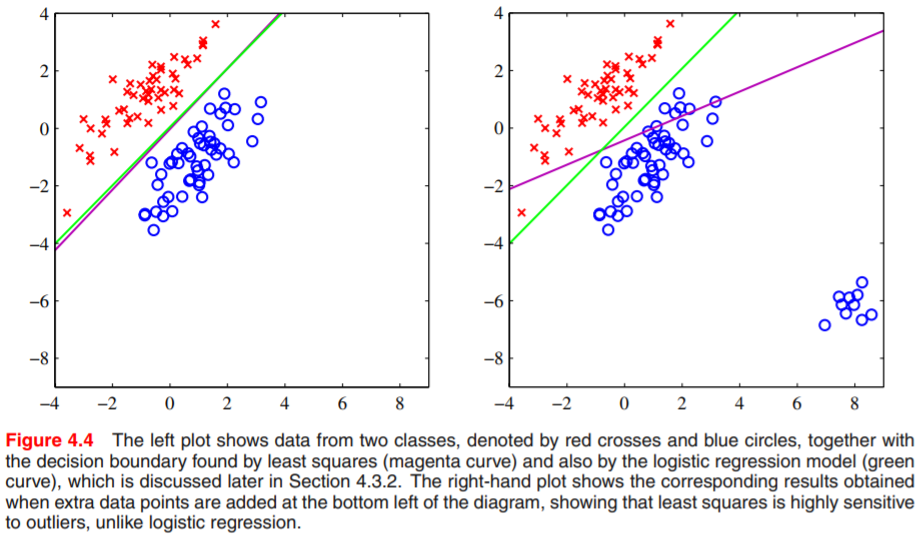

In [1]:
from IPython.display import Image
Image('figures/Figure4.4.png', width=700)

More discussions on board notes.

---

# Logistic Regression

Let's import a classification dataset: the iris dataset.

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
iris = load_iris(as_frame=False)

In [ ]:
iris.keys()

Datasets loaded by ```sklearn``` generally have a similar disctionary structure, including the following:

* A ```DESCR``` key describing the dataset
* A ```data``` key containing an array with one row per instance and one column per feature
* A ```target``` key containing an array with the labels

In [ ]:
# print(iris.DESCR)

In [ ]:
# iris.data

In [ ]:
iris.data.shape, iris.target.shape

In [ ]:
iris.feature_names

There are 150 samples, and each sample has 4 features (sepal length, sepal width, petal length and petal width).

In [ ]:
np.unique(iris.target, return_counts=True)

In [ ]:
iris.target_names

Each sample is classified as one of 3 classes: 0 is setosa, 1 is versicolor, and 2 is virginica.

For visualization purposes, let's consider only features **petal length** and **petal width**.

In [ ]:
X = iris.data[:,2:]

X.shape

## Training a Binary Classifier

Let's simplify the problem for now and only try to identify one iris species - for example, the **class setosa**. This "setosa-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, setosa and not-setosa. Let's create the target vectors for this classification task:

In [ ]:
t = 1*(iris.target == 0)

In [ ]:
t

In [ ]:
plt.scatter(X[t==0,0], X[t==0,1], c='b', edgecolors='k', alpha=0.7, label='Not-Setosa')
plt.scatter(X[t==1,0], X[t==1,1], c='r', edgecolors='k', alpha=0.7, label='Setosa')
plt.xlabel(iris.feature_names[2], size=15)
plt.ylabel(iris.feature_names[3], size=15)
plt.legend(bbox_to_anchor=(1,1),fontsize=15);

___

# Logistic Regression, also called *Logit* Regression or Logistic Discrimination

*Note that, despite of its name, logistic regression is a model for classification, not regression.*

The **logistic discriminant** is a linear model for binary classification that can be extended to multi-class classification using the one-vs-all approach.

Logistic regression is a **probabilistic discriminative classifier**.

In logistic logistic discrimination, we do not model the class-conditional densities, $p(x|C_i)$, but rather their ratio. Let us assume we are working with a two-class problem and assume that the log likelihood ratio (or **odds ratio**) is linear:

\begin{align*}
\log\frac{P(x|C_1)}{P(x|C_2)} = \mathbf{w}^Tx + b
\end{align*}

* This is only true, if the classes are Gaussian-distributed!

* But logistic discrimination has a wider scope of applicability; for example, $x$ may be composed of discrete attributes or may be a mixture of continuous and discrete attributes. Using Bayes’ rule, we have:

\begin{align*}
\operatorname{logit} P(C_1|x) &=\log \frac{P(C_1|x)}{1-P(C_1|x)}\\
&= \log \frac{P(x|C_1)}{P(x|C_2)} + \log \frac{P(C_1)}{P(C_2)} \\
&= \mathbf{w}^Tx + w_0
\end{align*}

where $w_0 = b + \log \frac{P(C_1)}{P(C_2)}$.

Rearranging terms, we get the probabilistic classification:

\begin{align*}
y = P(C_1|x) = \frac{1}{1+\exp\left(-(\mathbf{w}^Tx+w_0)\right)}
\end{align*}

This is the sigmoid function:

\begin{align*}
\phi(z) = \frac{1}{1+\exp(-z)}
\end{align*}

In [ ]:
z = np.linspace(-8,8,100)

plt.figure(figsize=(7,5))
plt.plot(z, 1/(1+np.exp(-z)))
plt.plot(z, [0.5]*len(z),'--')
plt.xlabel('$z$',size=20); plt.ylabel('$\phi(z)$',size=20);
plt.title('Sigmoid Function',size=15);

* We can see that $\phi(z)\rightarrow 1$ as $z\rightarrow\infty$, since $\exp(-z)$ becomes very small for large values of $z$.

* Similarly, $\phi(z)\rightarrow 0$ as $z\rightarrow -\infty$ as the result of an increasingly large denominator. 

Thus, we conclude that this sigmoid function takes real number values as input and transforms them to values in the range $[0, 1]$ with an intercept at $\phi(z)=0.5$.

This is the same as using a sigmoid function as the **activation function** in the perceptron diagram.

Thus the output of the sigmoid function is then interpreted as the probability of particular sample belonging to $C_1$, given its features $x$ parameterized by the weights $w$. 

* For example, if we compute $\phi(z)=0.8$ for a particular sample, it means that the chance that this sample is in $C_1$ is 80%. 

The predicted probability can then simply be converted into a binary outcome via a quantizer (unit step function):

\begin{align*}
\hat{t} = y &= \begin{cases}1, & \phi(z)\geq 0.5\\ 0, & \text{otherwise}\end{cases}\\
&=\begin{cases}1, & \phi(\mathbf{w}^Tx+w_0)\geq 0.5\\ 0, & \text{otherwise}\end{cases}
\end{align*}

or,

\begin{align*}
\hat{t} = y &= \begin{cases}1, & z\geq 0\\ 0, & z<0\end{cases} \\
&= \begin{cases}1, & \mathbf{w}^Tx+w_0\geq 0\\ 0, & \mathbf{w}^Tx+w_0<0\end{cases}
\end{align*}

## The Objective Function

Let $\{(x_i,t_i)\}_{i=1}^N$ be the set of input samples and its class labels, where $t_i\in\{0,1\}$. Assuming the data samples are i.i.d., we can build the observed data likelihood:

\begin{align*}
\mathcal{L}^0 = \prod_{i=1}^N P(y_i|x_i; \mathbf{w}) = \phi(z_i)^{t_i}(1-\phi(z_i))^{1-t_i}
\end{align*}

We can apply the "trick" (log-likelihood) to build the data likelihood":

\begin{align*}
\mathcal{L} = \sum_{i=1}^N t_i\log\phi(z_i) +(1-t_i)\log(1-\phi(z_i))
\end{align*}

where $\phi(z) = \frac{1}{1+\exp(-z)}$ and $z_i = \mathbf{w}^Tx_i+w_0$.

We want to maximize this likelihood to the data, or we can also write it as a minimization optimization:

\begin{align*}
J(\mathbf{w},w_0) = \sum_{i=1}^N - t_i\log\phi(z_i) - (1-t_i)\log(1-\phi(z_i))
\end{align*}

This objective function is also known as **cross-entropy**.

In [ ]:
z = np.linspace(-2,2,100)

phi = lambda z: 1/(1+np.exp(-z))

plt.figure(figsize=(7,5))
plt.plot(phi(z), -np.log(phi(z)),label='when $t=1$')
plt.plot(phi(z), -np.log(1-phi(z)),'--',label='when $t=0$')
plt.legend(fontsize=15); plt.xlabel('$\phi(z)$',size=20)
plt.ylabel('$J(\mathbf{w})$',size=20);

In [ ]:
plt.plot(z, -np.log(phi(z))-np.log(1-phi(z)),'--',label='$J(w,w_0)$')
plt.legend(fontsize=20);

We can see that the cost approaches 0 if we correctly predict that a sample belongs to class 1. Similarly, we can see on the y axis that the cost also approaches 0 if we correctly predict class 0. However, if the prediction is wrong, the cost goes towards infinity: we penalize wrong predictions with an increasingly larger cost.

As we do not have the global *picture* of what the objective function, $J(\mathbf{w})$, we apply a search method to navigate through the objective function to find the *local optima* starting from an initial value, namely, **gradient descent**.

\begin{align*}
\mathbf{w}^{(t+1)} \longleftarrow \mathbf{w}^{(t)} - \eta \frac{\partial J(\mathbf{w})}{\partial \mathbf{w}^{(t)}}
\end{align*}

\begin{align*}
\mathbf{w_0}^{(t+1)} \longleftarrow \mathbf{w_0}^{(t)} - \eta \frac{\partial J(\mathbf{w})}{\partial \mathbf{w_0}^{(t)}}
\end{align*}

where $\eta$ is the learning rate (or step size).

\begin{align*}
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}^{(t)}} =
\sum_{i=1}^N -t_i\frac{1}{\phi(z_i)}\frac{\partial\phi(z_i)}{\partial z_i}\frac{\partial z_i}{\partial\mathbf{w}} -(1-t_i)\frac{1}{1-\phi(z_i)}\left(-\frac{\partial\phi(z_i)}{\partial z_i}\frac{\partial z_i}{\partial\mathbf{w}}\right)
\end{align*}

where $\frac{\partial\phi(z_i)}{\partial z_i} = \phi'(z_i)$ and $\frac{\partial z_i}{\partial\mathbf{w}} = x_i$. Substituting:

\begin{align*}
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}^{(t)}} &= \sum_{i=1}^N -t_i \frac{\phi'(z_i)}{\phi(z_i)} x_i + (1-t_i)\frac{\phi'(z_i)}{1-\phi(z_i)} x_i \\
&= \sum_{i=1}^N \left(\frac{t_i}{\phi(z_i)} - \frac{1-t_i}{1-\phi(z_i)}\right)\phi'(z_i)x_i
\end{align*}

where $\phi'(z_i)= \phi(z_i)(1-\phi(z_i))$, then applying some substitutions we have:

\begin{align*}
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}^{(t)}} = \sum_{i=1}^N (t_i - y_i)x_i
\end{align*}

and, similarly,

\begin{align*}
\frac{\partial J(\mathbf{w})}{\partial w_0^{(t)}} = \sum_{i=1}^N (t_i - y_i)
\end{align*}

Finally,

\begin{align*}
\mathbf{w}^{(t+1)} \longleftarrow \mathbf{w}^{(t)} - \eta \sum_{i=1}^N (t_i - y_i)x_i
\end{align*}

\begin{align*}
\mathbf{w_0}^{(t+1)} \longleftarrow \mathbf{w_0}^{(t)} - \eta \sum_{i=1}^N (t_i - y_i)
\end{align*}

**Initialization:** it is best to initialize $\mathbf{w}$ with random values close to 0; generally they are drawn uniformly from the interval $[−0.01, 0.01]$. 

* The reason for this is that if the initial $\mathbf{w}$ are large in magnitude, the weighted sum may also be large and may saturate the sigmoid. 

* If the initial weights are close to 0, the sum will stay in the middle region where the derivative is nonzero and an update can take place. 

* If the weighted sum is large in magnitude (smaller than −5 or larger than +5), the derivative of the sigmoid will be almost 0 and weights will not be updated. 
    * When we stack up a lot of these perceptrons in layers and add a few layers, this "close to 0" gradient will lead to a phenomenon in neural networks known as the **vanishing gradient**.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(penalty='none')

In [ ]:
log_reg.fit(X, t)

In [ ]:
log_reg.intercept_

In [ ]:
log_reg.coef_

In [ ]:
plt.scatter(X[t==0,0], X[t==0,1], c='r', edgecolors='k', alpha=0.7, label='Not-Setosa')
plt.scatter(X[t==1,0], X[t==1,1], c='b', edgecolors='k', alpha=0.7, label='Setosa')
plt.xlabel(iris.feature_names[2], size=15)
plt.ylabel(iris.feature_names[3], size=15)
plt.legend(bbox_to_anchor=(1,1),fontsize=15);

In [ ]:
# generate synthetic data in the 2-D feature space

xx, yy = np.meshgrid(np.arange(0, 8, 0.01),
                     np.arange(-1, 3, 0.01))

mesh = np.vstack((xx.ravel(), yy.ravel())).T

xx.shape, yy.shape, mesh.shape

In [ ]:
sigmoid = lambda x: 1/(1+np.exp(-x))

In [ ]:
# Making predictions

#y = sigmoid(w^T@x + b) = sigmoid(x@w^T + b)

sigmoid(mesh@log_reg.coef_.T + log_reg.intercept_)

In [ ]:
probs = log_reg.predict_proba(mesh)

probs

In [ ]:
plt.figure(figsize=(10,5))
plt.contourf(xx, yy, probs[:,1].reshape(xx.shape), cmap=plt.cm.RdBu, alpha=.8)
plt.scatter(X[:,0], X[:,1], c=t, cmap=plt.cm.RdBu)
plt.rcParams['axes.grid'] = False #runtime configuration (rc) settings
plt.colorbar();

In [ ]:
labels = log_reg.predict(mesh)

labels

In [ ]:
plt.figure(figsize=(10,5))
plt.contourf(xx, yy, labels.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=.8)
plt.scatter(X[:,0], X[:,1], c=t, cmap=plt.cm.RdBu)
plt.rcParams['axes.grid'] = False #runtime configuration (rc) settings
plt.colorbar();

## Multiple Classes

Considering the extension of linear discriminants to $K > 2$ classes. We might be tempted be to build a $K$-class discriminant by combining a number of two-class discriminant functions. However, this leads to some serious difficulties.

* Consider the use of $K−1$ classifiers each of which solves a two-class problem of separating points in a particular class $C_k$ from points not in that class. This is known as a **one-versus-all** classifier.

* An alternative is to introduce $K(K − 1)/2$ binary discriminant functions, one for every possible pair of classes. This is known as a **one-versus-one** classifier. Each point is then classified according to a majority vote amongst the discriminant functions. However, this too runs into the problem of ambiguous regions.

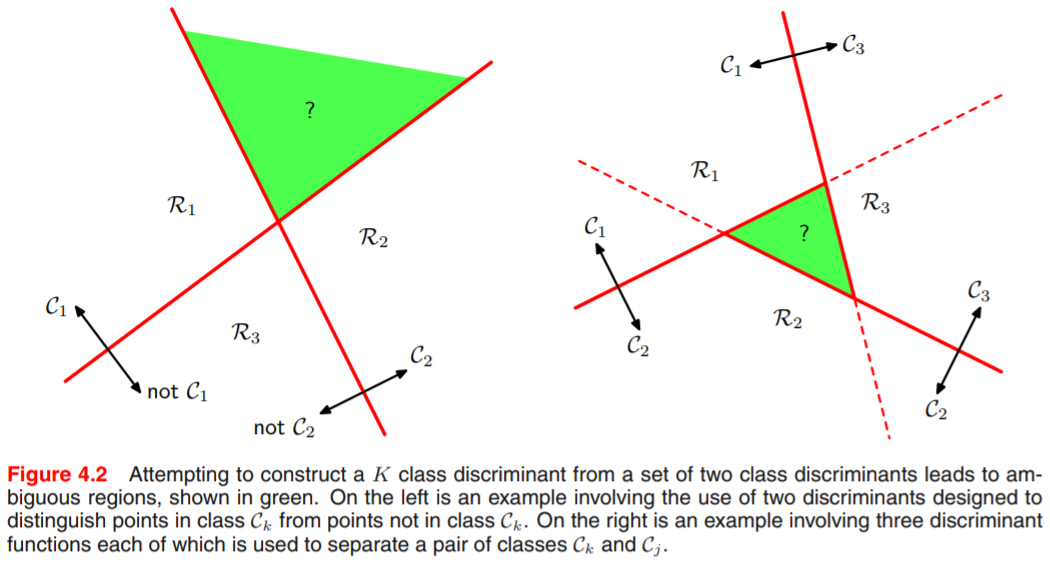

In [2]:
Image('figures/Figure4.2.png',width=700)
# Source: Bishop textbook

## Softmax Regression

We can avoid these difficulties by considering a **single $K$-class discriminant** comprising $K$ linear functions of the form

\begin{align*}
y_k(\mathbf{x}) = \phi(\mathbf{w}_k^T\mathbf{x} + b_k)
\end{align*}

and then assigning a point $\mathbf{x}$ to class $C_k$ if $y_k(\mathbf{x}) > y_j(\mathbf{x})$ for all $j \neq k$. The decision
boundary between class $C_k$ and class $C_j$ is therefore given by $y_k(\mathbf{x}) = y_j(\mathbf{x})$ and hence corresponds to a $(D − 1)$-dimensional hyperplane defined by

\begin{align*}
(\mathbf{w}_k - \mathbf{w}_j)^T\mathbf{x} + (b_k - bj) = 0
\end{align*}

This has the same form as the decision boundary for the two-class case.

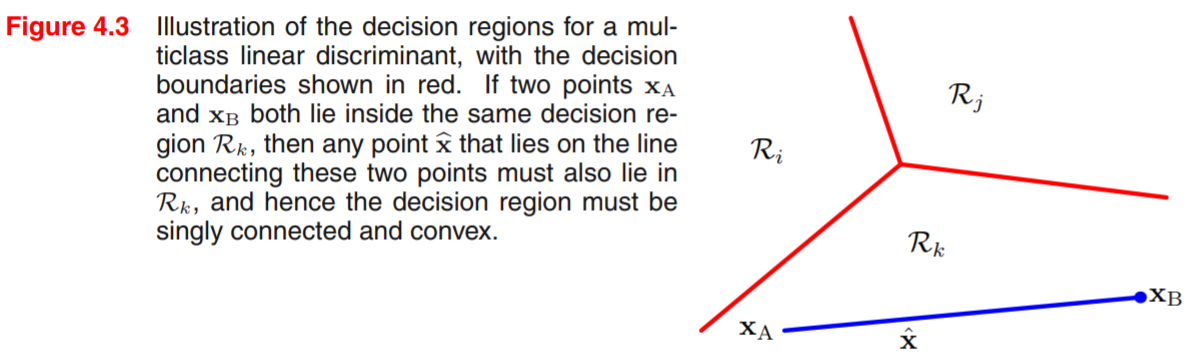

In [3]:
Image('figures/Figure4.3.png',width=800)
# Source: Bishop textbook

The decision regions of such a discriminant are always **singly connected** and **convex**.

Once you have computed the score of every class for the instance $\mathbf{x}$, i.e. $y_k(\mathbf{x})$, you can estimate the probability $p_k$ that the instance belongs to class $k$ by running the scores through the **softmax function**.

\begin{align*}
p_k = \frac{\exp(y_k(\mathbf{x}))}{\sum_{j=1}^K \exp(y_j(\mathbf{x}))}
\end{align*}

The function computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials). The scores are generally called logits or log-odds (although they are actually unnormalized log-odds).

The derivations will be derived in the same way as earlier (left as exercise).

In [ ]:
X = iris.data[:,2:]

t = iris.target

t

In [ ]:
log_reg = LogisticRegression(multi_class='multinomial', penalty='none')

In [ ]:
log_reg.fit(X, t)

In [ ]:
probs = log_reg.predict_proba(mesh)

probs

In [ ]:
pred = log_reg.predict(mesh)

pred

In [ ]:
plt.figure(figsize=(10,5))
plt.contourf(xx, yy, pred.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=.8)
plt.scatter(X[:,0], X[:,1], c=t, cmap=plt.cm.RdBu)
plt.rcParams['axes.grid'] = False #runtime configuration (rc) settings
plt.colorbar();

---